# Model Representation Examples
## Produce the AskeNet Model Representation of "toy" SIR-based models by converting from template to MIRA to Aske representations.

In [1]:
import mira
from mira.metamodel import Concept, ControlledConversion, GroupedControlledConversion, Initial, NaturalConversion, Parameter, Template, TemplateModel
from mira.modeling.viz import GraphicalModel
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel

from pyciemss.interfaces import setup_model, calibrate, intervene
from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_petri_model

import sympy

## Define `Concepts` (model state variables) and total population

In [2]:
susceptible = Concept(name="susceptible_population", identifiers={"ido": "0000514"})
exposed = Concept(name="exposed_population", identifiers={"ido": "0000594"}) # http://purl.obolibrary.org/obo/IDO_0000594
infectious = Concept(name="infectious_population", identifiers={"ido": "0000513"}) # http://purl.obolibrary.org/obo/IDO_0000513
symptomatic = Concept(name="symptomatic_population", identifiers={"ido": "0000573"}) # http://purl.obolibrary.org/obo/IDO_0000573
asymptomatic = Concept(name="asymptomatic_population", identifiers={"ido": "0000569"}) # http://purl.obolibrary.org/obo/IDO_0000569
recovered = Concept(name="recovered_population", identifiers={"ido": "0000592"})
hospitalized = Concept(name="hospitalized_population", identifiers={"ncit": "C25179"})
deceased = Concept(name="deceased_population", identifiers={"ncit": "C168970"}) # http://purl.obolibrary.org/obo/NCIT_C168970

# Set a value for the total population
total_pop = 100000

# Model 1: SIRHD
Model 1 state variables: Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), and Deceased (D)

## Define conversion templates for Model 1

In [3]:
state_variables = "beta, total_population, susceptible_population, delta, infectious_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population"
beta, N, S, delta, I, gamma, hosp, dnh, dh, los, H, R, D = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_I = ControlledConversion(
    controller = infectious,
    subject=susceptible,
    outcome=infectious,
    rate_law=(beta/N)*S*I
)
I_to_R = NaturalConversion(
    subject=infectious,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=infectious,
    outcome=hospitalized,
    rate_law=gamma*hosp*I
)
I_to_D = NaturalConversion(
    subject=infectious,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)

# display(S_to_E.rate_law.args[0])

## Set up the template model, define parameter values and initial conditions

In [4]:
tm1 = TemplateModel(
    templates=[S_to_I, I_to_R, I_to_H, I_to_D, H_to_R, H_to_D],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'infectious_population': (Initial(concept=infectious, value=1)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm1)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

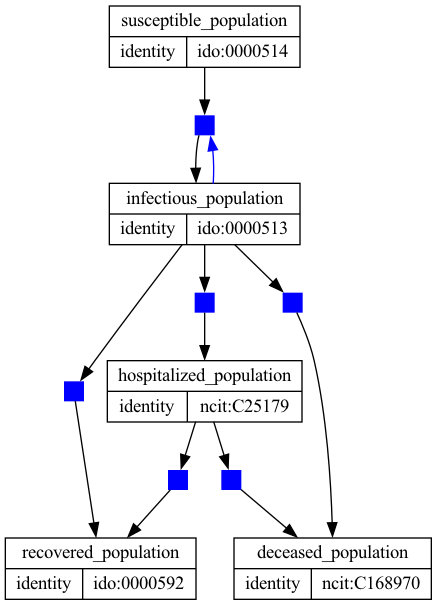

In [5]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm1, width="20%")

## Convert to MIRA model representation

In [6]:
mira_m1 = Model(tm1)
display(type(mira_m1)) 
#mira_m.variables

mira.modeling.Model

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [7]:
aske_m1 = AskeNetPetriNetModel(mira_m1)

# Display AMR model in JSON format
display(aske_m1.to_json())

# Save AMR model as JSON file
aske_m1.to_json_file("SIRHD_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'infectious_population',
    'name': 'infectious_population',
    'grounding': {'identifiers': {'ido': '0000513'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'hospitalized_population',
    'name': 'hospitalized_population',
    'grounding': {'identifiers': {'ncit': 'C25179'}, 'modifiers': {}}},
   {'id': 'deceased_population',
    'name': 'deceased_population',
    'grounding': {'identifiers': {'ncit': 'C168970'}, 'modifiers': {}}}],
  'transitions': [

In [8]:
# Import mira_m the pyciemss way
the_model = load_petri_model(mira_m1) 
the_model

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('infectious_population', ('identity', 'ido:0000513')), ('infectious_population', ('identity', 'ido:0000513')), 'ControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	gamma = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	hosp = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	dnh = Uniform(low: 0.0008999999845400453, high: 0.0010999999940395355),
	(('infectious_population', ('identity', 'ido:0000513')), ('recovered_population', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('infectious_population', ('identity', 'ido:0000513')), ('hospitalized_population', ('identity', 'ncit:C25179')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('infectious_population', ('identity',

In [15]:
sirhd_amr = load_petri_model("SIRHD_AMR.json")
sirhd_amr 

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 4.949999947712058e-06, high: 6.050000138202449e-06),
	mira_param_1 = Uniform(low: 0.16181999444961548, high: 0.19777999818325043),
	mira_param_2 = Uniform(low: 0.017999999225139618, high: 0.02199999988079071),
	mira_param_3 = Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015),
	mira_param_4 = Uniform(low: 0.11571428924798965, high: 0.14142857491970062),
	mira_param_5 = Uniform(low: 0.012857142835855484, high: 0.015714285895228386),
	pseudocount = 1.0
)

# Model 2: SEIARHD
Model 2 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), <br> and Deceased (D)

## Define conversion templates for Model 2

In [10]:
state_variables = "beta, total_population, susceptible_population, delta, symptomatic_population, asymptomatic_population, pS, alpha, exposed_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population"
beta, N, S, delta, I, A, pS, alpha, E, gamma, hosp, dnh, dh, los, H, R, D = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_E = GroupedControlledConversion(
    controllers = [
        symptomatic, 
        asymptomatic, 
    ],
    subject=susceptible,
    outcome=exposed,
    rate_law=(beta/N)*S*(delta*I + A)
)
E_to_I = NaturalConversion(
    subject=exposed,
    outcome=symptomatic,
    rate_law=(pS/alpha)*E
)
E_to_A = NaturalConversion(
    subject=exposed,
    outcome=asymptomatic,
    rate_law=((1-pS)/alpha)*E
)
I_to_R = NaturalConversion(
    subject=symptomatic,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=symptomatic,
    outcome=hospitalized,
    rate_law=gamma*hosp*I
)
I_to_D = NaturalConversion(
    subject=symptomatic,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
A_to_R = NaturalConversion(
    subject=asymptomatic,
    outcome=recovered,
    rate_law=gamma*A
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)

# display(S_to_E.rate_law.args[0])

## Set up the template model, define parameter values and initial conditions

In [11]:
tm2 = TemplateModel(
    templates=[S_to_E, E_to_I, E_to_A, I_to_R, I_to_H, I_to_D, A_to_R, H_to_R, H_to_D],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'delta': Parameter(name='delta', value=1.5), # difference in infectiousness symptomatic/asymptomatic
        'pS': Parameter(name='pS', value=0.7), # percent of exposures which become symptomatic
        'alpha': Parameter(name='alpha', value=4), # latency period
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'symptomatic_population': (Initial(concept=symptomatic, value=1)),
        'asymptomatic_population': (Initial(concept=asymptomatic, value=0)),
        'exposed_population': (Initial(concept=exposed, value=0)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm2)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

In [55]:
type(tm2.templates[0].rate_law)


mira.metamodel.templates.SympyExprStr

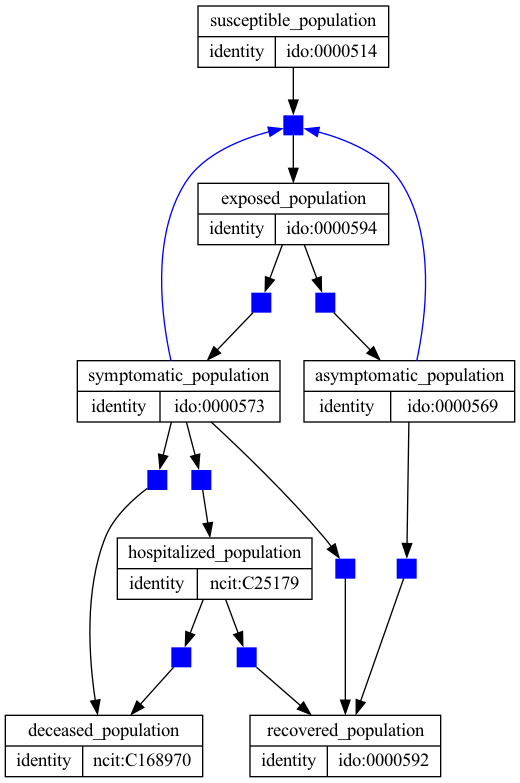

In [12]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm2, width="20%")

## Convert to MIRA model representation 

In [13]:
mira_m2 = Model(tm2)
display(type(mira_m2)) 
#mira_m.variables

mira.modeling.Model

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [14]:
aske_m2 = AskeNetPetriNetModel(mira_m2)

# Display AMR model in JSON format
display(aske_m2.to_json())

# Save AMR model as JSON file
aske_m2.to_json_file("SEIARHD_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'symptomatic_population',
    'name': 'symptomatic_population',
    'grounding': {'identifiers': {'ido': '0000573'}, 'modifiers': {}}},
   {'id': 'asymptomatic_population',
    'name': 'asymptomatic_population',
    'grounding': {'identifiers': {'ido': '0000569'}, 'modifiers': {}}},
   {'id': 'exposed_population',
    'name': 'exposed_population',
    'grounding': {'identifiers': {'ido': '0000594'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'hospitali

In [17]:
# Import mira_m the pyciemss way
the_model = load_petri_model(mira_m2) 
the_model

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('symptomatic_population', ('identity', 'ido:0000573')), ('asymptomatic_population', ('identity', 'ido:0000569'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	alpha = Uniform(low: 3.5999999046325684, high: 4.400000095367432),
	pS = Uniform(low: 0.6299999952316284, high: 0.7699999809265137),
	(('exposed_population', ('identity', 'ido:0000594')), ('symptomatic_population', ('identity', 'ido:0000573')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('exposed_population', ('identity', 'ido:0000594')), ('asymptomatic_population', ('identity', 'ido:0000569')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, hig

In [18]:
SEIARHD_amr = load_petri_model("SEIARHD_AMR.json")
SEIARHD_amr

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('asymptomatic_population', ('identity', 'ido:0000569')), ('symptomatic_population', ('identity', 'ido:0000573'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	mira_param_0 = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	mira_param_1 = Uniform(low: 0.06750000268220901, high: 0.08250000327825546),
	mira_param_2 = Uniform(low: 0.16181999444961548, high: 0.19777999818325043),
	mira_param_3 = Uniform(low: 0.017999999225139618, high: 0.02199999988079071),
	mira_param_4 = Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015),
	mira_param_5 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),

# Model 3: SEIARHDS
Model 3 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), <br> and Deceased (D)

## Define conversion templates for Model 1

In [50]:
state_variables = "beta, total_population, susceptible_population, delta, symptomatic_population, asymptomatic_population, pS, alpha, exposed_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population, tau"
beta, N, S, delta, I, A, pS, alpha, E, gamma, hosp, dnh, dh, los, H, R, D, tau = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_E = GroupedControlledConversion(
    controllers = [
        symptomatic, 
        asymptomatic, 
    ],
    subject=susceptible,
    outcome=exposed,
    rate_law=(beta/N)*S*(delta*I + A)
)
E_to_I = NaturalConversion(
    subject=exposed,
    outcome=symptomatic,
    rate_law=(pS/alpha)*E
)
E_to_A = NaturalConversion(
    subject=exposed,
    outcome=asymptomatic,
    rate_law=((1-pS)/alpha)*E
)
I_to_R = NaturalConversion(
    subject=symptomatic,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=symptomatic,
    outcome=hospitalized,
    rate_law=gamma*hosp*I
)
I_to_D = NaturalConversion(
    subject=symptomatic,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
A_to_R = NaturalConversion(
    subject=asymptomatic,
    outcome=recovered,
    rate_law=gamma*A
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)
R_to_S = NaturalConversion(
    subject=recovered,
    outcome=susceptible,
    rate_law=(1/tau)*R
)

display(S_to_E.rate_law.args[0])

beta*susceptible_population*(asymptomatic_population + delta*symptomatic_population)/total_population

## Set up the template model, define parameter values and initial conditions

In [20]:
tm3 = TemplateModel(
    templates=[S_to_E, E_to_I, E_to_A, I_to_R, I_to_H, I_to_D, A_to_R, H_to_R, H_to_D, R_to_S],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'delta': Parameter(name='delta', value=1.5), # difference in infectiousness symptomatic/asymptomatic
        'pS': Parameter(name='pS', value=0.7), # percent of exposures which become symptomatic
        'alpha': Parameter(name='alpha', value=4), # latency period
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
        'tau': Parameter(name='tau', value=30), # period of immunity from recovery (days)
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'symptomatic_population': (Initial(concept=symptomatic, value=1)),
        'asymptomatic_population': (Initial(concept=asymptomatic, value=0)),
        'exposed_population': (Initial(concept=exposed, value=0)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm3)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

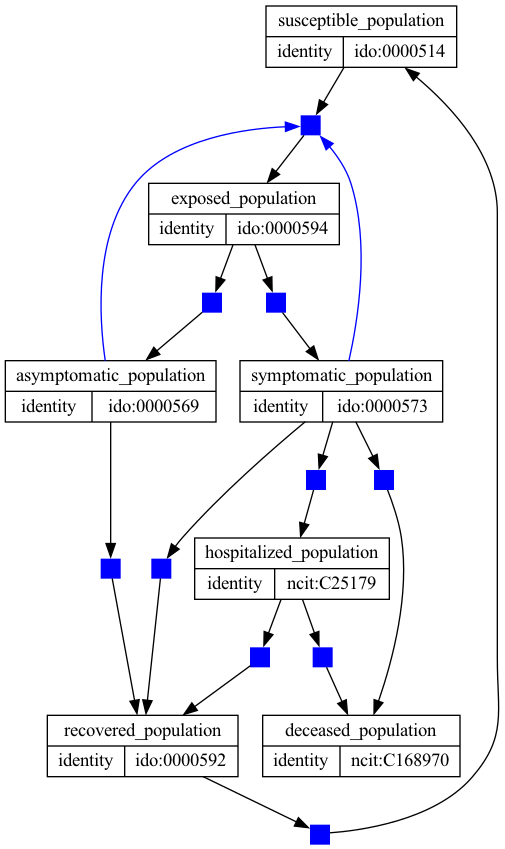

In [21]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm3, width="20%")

## Convert to MIRA model representation

In [51]:
mira_m3 = Model(tm3)
#display(type(mira_m3)) 
for t in mira_m3.template_model.transitions:
    r = mira_m3.template_model.transitions[t].rate_law
    print(r)

AttributeError: 'TemplateModel' object has no attribute 'transitions'

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [24]:
aske_m3 = AskeNetPetriNetModel(mira_m3)

# Display AMR model in JSON format
display(aske_m3.to_json())

# Save AMR model as JSON file
aske_m3.to_json_file("SEIARHDS_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'symptomatic_population',
    'name': 'symptomatic_population',
    'grounding': {'identifiers': {'ido': '0000573'}, 'modifiers': {}}},
   {'id': 'asymptomatic_population',
    'name': 'asymptomatic_population',
    'grounding': {'identifiers': {'ido': '0000569'}, 'modifiers': {}}},
   {'id': 'exposed_population',
    'name': 'exposed_population',
    'grounding': {'identifiers': {'ido': '0000594'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'hospitali

In [36]:
# Import mira_m the pyciemss way
the_model = load_petri_model(mira_m3) 
the_model.G.transitions

TypeError: '<=' not supported between instances of 'Uniform' and 'int'

In [27]:
SEIARHDS_amr = load_petri_model("SEIARHDS_AMR.json")
SEIARHDS_amr

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('asymptomatic_population', ('identity', 'ido:0000569')), ('symptomatic_population', ('identity', 'ido:0000573'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	mira_param_0 = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	mira_param_1 = Uniform(low: 0.06750000268220901, high: 0.08250000327825546),
	mira_param_2 = Uniform(low: 0.16181999444961548, high: 0.19777999818325043),
	mira_param_3 = Uniform(low: 0.017999999225139618, high: 0.02199999988079071),
	mira_param_4 = Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015),
	mira_param_5 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),

In [47]:
for t in SEIARHDS_amr.G.transitions:
    r = SEIARHDS_amr.G.transitions[t].rate
    print(r.key, r.value)


(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('asymptomatic_population', ('identity', 'ido:0000569')), ('symptomatic_population', ('identity', 'ido:0000573'))), 'GroupedControlledConversion', 'rate') Uniform(low: 0.0, high: 1.0)
mira_param_0 Uniform(low: 0.1574999988079071, high: 0.19249999523162842)
mira_param_1 Uniform(low: 0.06750000268220901, high: 0.08250000327825546)
mira_param_2 Uniform(low: 0.16181999444961548, high: 0.19777999818325043)
mira_param_3 Uniform(low: 0.017999999225139618, high: 0.02199999988079071)
mira_param_4 Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015)
mira_param_5 Uniform(low: 0.18000000715255737, high: 0.2199999988079071)
mira_param_6 Uniform(low: 0.11571428924798965, high: 0.14142857491970062)
mira_param_7 Uniform(low: 0.012857142835855484, high: 0.015714285895228386)
mira_param_8 Uniform(low: 0.029999999329447746, high: 0.036666665226221085)
